# Similarity Encoders with PyTorch
## using the model definition from `simec_torch.py`

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
from time import time
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn.metrics.pairwise import linear_kernel
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_mldata, make_s_curve

from simec_torch import SimilarityEncoder
from utils import center_K, check_embed_match, check_similarity_match
from utils_plotting import plot_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MNIST with Linear Kernel

In [2]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

In [3]:
# centered linear kernel matrix
K_lin = center_K(np.dot(X, X.T))

error similarity match: msqe: 51.4531662441 ; r^2: 0.4438507851 ; rho: 0.6341602248


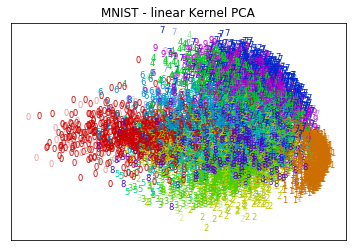

In [4]:
# linear kPCA
kpca = KernelPCA(n_components=2, kernel='linear')
X_embed = kpca.fit_transform(X)
X_embed_test = kpca.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - linear Kernel PCA')
print("error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embed, K_lin))

[epoch 1] loss: 87.5994047
[epoch 2] loss: 74.4213880
[epoch 3] loss: 67.4189396
[epoch 4] loss: 63.1068671
[epoch 5] loss: 60.0767430
[epoch 6] loss: 57.8836558
[epoch 7] loss: 56.2715808
[epoch 8] loss: 55.0827653
[epoch 9] loss: 54.2103255
[epoch 10] loss: 53.5704236
[epoch 11] loss: 53.1003182
[epoch 12] loss: 52.7576206
[epoch 13] loss: 52.5057928
[epoch 14] loss: 52.3236998
[epoch 15] loss: 52.1937480
[epoch 16] loss: 52.0981192
[epoch 17] loss: 52.0305122
[epoch 18] loss: 51.9839460
[epoch 19] loss: 51.9523176
[epoch 20] loss: 51.9300345
[epoch 21] loss: 51.9144353
[epoch 22] loss: 51.9049209
[epoch 23] loss: 51.9005152
[epoch 24] loss: 51.8986192
[epoch 25] loss: 51.8968010
correlation with lin kPCA       : 0.962627
correlation with lin kPCA (test): 0.965359
error similarity match: msqe: 51.8039170991 ; r^2: 0.4400881333 ; rho: 0.6310763322
error similarity match: msqe: 51.8966014009 ; r^2: 0.4380937672 ; rho: 0.6308187686


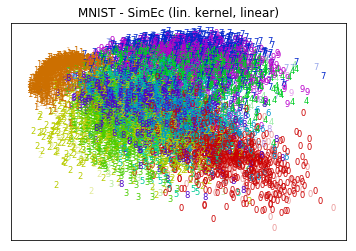

In [5]:
# on how many target similarities you want to train - faster and works equally well than training on all
n_targets = 1000  # K_lin.shape[1]
# initialize the model
simec = SimilarityEncoder(X.shape[1], 2, n_targets)
# train the model to get an embedding with which the target similarities
# can be linearly approximated
simec.fit(X, K_lin[:,:n_targets], epochs=25, lr=0.001, s_ll_reg=500., S_ll=K_lin[:n_targets,:n_targets])
# get the embeddings
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (lin. kernel, linear)')
# correlation with the embedding produced by the spectral method should be high
print("correlation with lin kPCA       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with lin kPCA (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
# similarity match error should be similar to the one from kpca
print("error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_lin))
print("error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(simec.predict(X), K_lin[:,:n_targets], X_embed_is_S_approx=True))

### Non-linear MNIST embedding with isomap

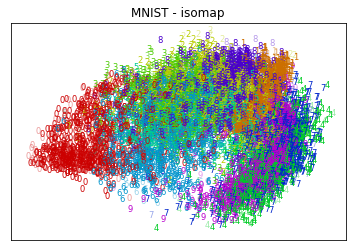

In [6]:
# isomap
isomap = Isomap(n_neighbors=10, n_components=2)
X_embed = isomap.fit_transform(X)
X_embed_test = isomap.transform(X_test)
plot_mnist(X_embed, y, X_embed_test, y_test, title='MNIST - isomap')

[epoch 1] loss: 31175.8980156
[epoch 2] loss: 26869.8870781
[epoch 3] loss: 23635.8417500
[epoch 4] loss: 21919.0307656
[epoch 5] loss: 21182.5821797
[epoch 6] loss: 20864.3568164
[epoch 7] loss: 20666.8206719
[epoch 8] loss: 20559.8074648
[epoch 9] loss: 20490.7074961
[epoch 10] loss: 20442.9467500
[epoch 11] loss: 20421.9254805
[epoch 12] loss: 20394.9051445
[epoch 13] loss: 20365.2159531
[epoch 14] loss: 20341.8890664
[epoch 15] loss: 20314.5192305
[epoch 16] loss: 20288.2548555
[epoch 17] loss: 20271.6561250
[epoch 18] loss: 20259.2475664
[epoch 19] loss: 20251.3292422
[epoch 20] loss: 20239.0907109
[epoch 21] loss: 20226.7163828
[epoch 22] loss: 20218.8303320
[epoch 23] loss: 20212.1943047
[epoch 24] loss: 20203.5056055
[epoch 25] loss: 20195.0396602
correlation with isomap       : 0.844133
correlation with isomap (test): 0.739540
error similarity match: msqe: 20794.6231092192 ; r^2: 0.4267721809 ; rho: 0.6262250701
error similarity match: msqe: 20221.6382047073 ; r^2: 0.435156464

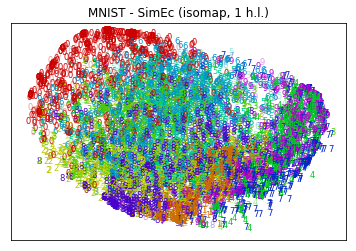

In [7]:
# non-linear SimEc to approximate isomap solution
K_geod = center_K(-0.5*(isomap.dist_matrix_**2))
n_targets = 1000
# initialize the model
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(20, 'tanh')])
# train the model to get an embedding with which the target similarities
# can be linearly approximated
simec.fit(X, K_geod[:,:n_targets], epochs=25, lr=0.01, s_ll_reg=500., S_ll=K_geod[:n_targets,:n_targets])
# get the embeddings
X_embeds = simec.transform(X)
X_embed_tests = simec.transform(X_test)
plot_mnist(X_embeds, y, X_embed_tests, y_test, title='MNIST - SimEc (isomap, 1 h.l.)')
print("correlation with isomap       : %f" % check_embed_match(X_embed, X_embeds)[1])
print("correlation with isomap (test): %f" % check_embed_match(X_embed_test, X_embed_tests)[1])
print("error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(X_embeds, K_geod))
print("error similarity match: msqe: %.10f ; r^2: %.10f ; rho: %.10f" % check_similarity_match(simec.predict(X), K_geod[:,:n_targets], X_embed_is_S_approx=True))

## Manifold learning: S-curve

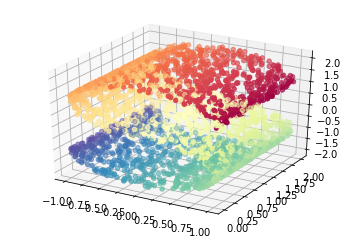

In [8]:
n_points = 3000
X, color = make_s_curve(n_points, random_state=0)
n_components = 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral);

PCA: 0.0019 sec
Isomap: 4.3 sec
[epoch 1] loss: 0.7107204
[epoch 2] loss: 0.1088471
[epoch 3] loss: 0.1064868
[epoch 4] loss: 0.1064868
[epoch 5] loss: 0.1064865
[epoch 6] loss: 0.1064865
[epoch 7] loss: 0.1064863
[epoch 8] loss: 0.1064861
[epoch 9] loss: 0.1064865
[epoch 10] loss: 0.1064862
[epoch 11] loss: 0.1064867
[epoch 12] loss: 0.1064863
[epoch 13] loss: 0.1064864
[epoch 14] loss: 0.1064872
[epoch 15] loss: 0.1064865
[epoch 16] loss: 0.1064876
[epoch 17] loss: 0.1064873
[epoch 18] loss: 0.1064867
[epoch 19] loss: 0.1064863
[epoch 20] loss: 0.1064868
[epoch 21] loss: 0.1064862
[epoch 22] loss: 0.1064871
[epoch 23] loss: 0.1064875
[epoch 24] loss: 0.1066580
[epoch 25] loss: 0.1074232
linear SimEc: 3.5 sec
[epoch 1] loss: 33.9025601
[epoch 2] loss: 5.4747324
[epoch 3] loss: 0.8243770
[epoch 4] loss: 0.2013551
[epoch 5] loss: 0.1463132
[epoch 6] loss: 0.1415248
[epoch 7] loss: 0.1397891
[epoch 8] loss: 0.1379660
[epoch 9] loss: 0.1363041
[epoch 10] loss: 0.1367699
[epoch 11] loss: 0

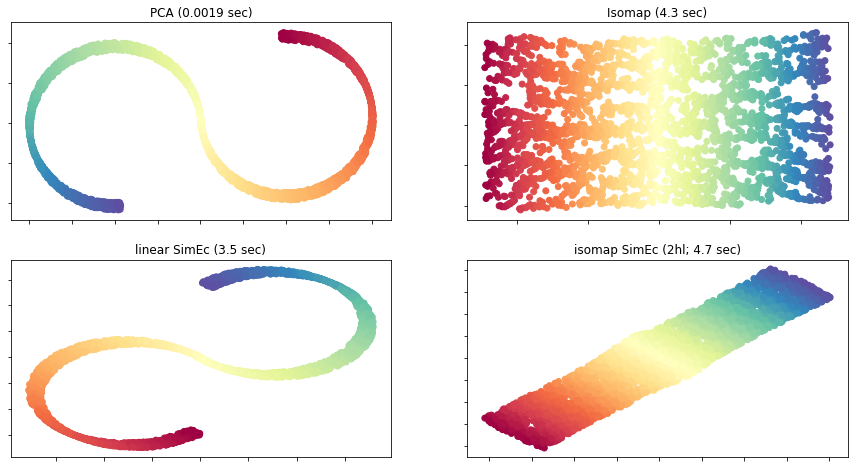

In [9]:
fig = plt.figure(figsize=(15, 8))

# PCA
t0 = time()
Y = PCA(n_components=2).fit_transform(X)
t1 = time()
print("PCA: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(221)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("PCA (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# Isomap
t0 = time()
isomap = Isomap(n_components=2, n_neighbors=10).fit(X)
Y = isomap.transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(222)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# simec with linear kernel --> global structure, like linear kpca
n_targets = 1000
K_lin = center_K(linear_kernel(X))
t0 = time()
simec = SimilarityEncoder(X.shape[1], 2, n_targets)
simec.fit(X, K_lin[:,:n_targets], lr=0.1, s_ll_reg=500., S_ll=K_lin[:n_targets,:n_targets])
Y = simec.transform(X)
t1 = time()
print("linear SimEc: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(223)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("linear SimEc (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

# simec with geodesic distance (from isomap) --> local manifold
# since the geodesic distance is not trivially derived from the original data
# like the linear kernel, we need to add non-linear hidden layers to get a
# good embedding similar to the original isomap embedding
G = center_K(-0.5*(isomap.dist_matrix_**2))
t0 = time()
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(25, "tanh"), (10, "tanh")])
simec.fit(X, G[:,:n_targets], lr=0.01, s_ll_reg=500., S_ll=G[:n_targets,:n_targets])
Y = simec.transform(X)
t1 = time()
print("isomap SimEc: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(224)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("isomap SimEc (2hl; %.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight');